# 风险溢价

## 加载模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from numpy.lib.stride_tricks import as_strided as stride

## 读入文件

In [2]:
df_merge = pd.read_csv('../data/stock-accounting.csv')
df_merge['date'] = pd.to_datetime(df_merge['date'])

## Fama-MacBeth 回归

剔除 `nan` 数据

In [142]:
idx_fac = ['beta', 'at', 'book-to-market', 'profit', 'investment', 'past-return']
df_fit = df_merge[['stg', 'RET-RF'] + idx_fac]
df_fit = df_fit.replace([np.inf, -np.inf], np.nan)
df_fit = df_fit.dropna()
df_fit.shape[0]

788528

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     335.3
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:03:16   Log-Likelihood:                -5181.5
No. Observations:               89146   AIC:                         1.038e+04
Df Residuals:                   89139   BIC:                         1.044e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0020      0.001     -2.

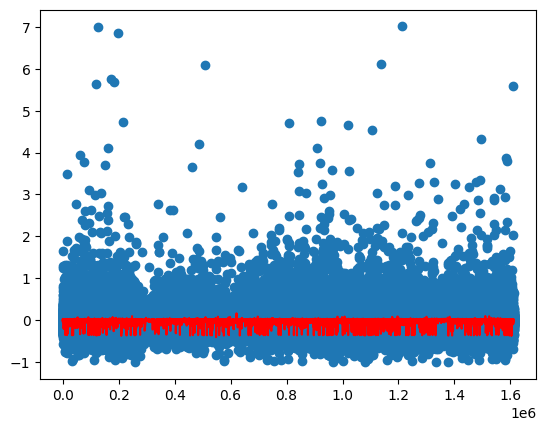

In [146]:
x = df_fit.loc[df_fit['stg'] == 'Intro', idx_fac]
z = (x - x.mean()) / x.std()
z[z > 3] = 3
z[z < -3] = -3
z = sm.add_constant(z)
y = df_fit.loc[df_fit['stg'] == 'Intro', 'RET-RF']
result = sm.OLS(y, z).fit()
print(result.summary())
print(result.params * 100)
y_pred = result.predict(z)
plt.scatter(z.index, y)
plt.plot(z.index, y_pred, color='red')
plt.show()

## 风险溢价估计

## 多空投资组合

## 滚动窗口估值

## EXHIBIT 9